<h1>LSA, или латентно-семантический анализ</h1><br>
<b>Латентно-семантический анализ (ЛСА)</b> (англ. Latent semantic analysis, <b>LSA</b>) — это метод обработки информации на естественном языке, анализирующий взаимосвязь между библиотекой документов и терминами, в них встречающимися, и выявляющий характерные факторы (тематики), присущие всем документам и терминам.


<b>ЛСА</b> используется для выявления латентных (скрытых) ассоциативно-семантических связей между термами (словами, н-граммами) путем сокращения факторного пространства термы-на-документы. Термами могут выступать как слова, так и их комбинации, т.наз. н-граммы, документами – в идеале: наборы тематически однородных текстов, либо просто любой желательно объемный текст (несколько млн. словоформ), произвольно разбитый на куски, например абзацы.


<h3>Немного истории</h3><br>
ЛСА был запатентован в 1988 году группой американских инжинеров-исследователей S.Deerwester.
В области информационного поиска данный подход называют латентно-семантическим индексированием (ЛСИ).
<br><br>
Впервые ЛСА был применен для автоматического индексирования текстов, выявления семантической структуры текста и получения псевдодокументов. Затем этот метод был довольно успешно использован для представления баз знаний и построения когнитивных моделей. В США этот метод был запатентован для проверки знаний школьников и студентов, а так же проверки качества обучающих методик.

<h3>Описание работы LSA</h3>
<br>
В качестве исходной информации ЛСА использует матрицу термы-на-документы (термы – слова, словосочетания или н-граммы; документы – тексты, классифицированные либо по какому-либо критерию, либо разделенные произвольным образом – это зависит от решаемой задачи), описывающую набор данных, используемый для обучения системы. Элементы этой матрицы содержат, как правило, веса, учитывающие частоты использования каждого терма в каждом документе или вероятностные меры (PLSA – вероятностный латентно-семантический анализ), основанные на независимом мультимодальном распределении.

Наиболее распространенный вариант ЛСА основан на использовании разложения вещественнозначной матрицы по сингулярным значениям или SVD-разложения (SVD – Singular Value Decomposition). С помощью него любую матрицу можно разложить в множество ортогональных матриц, линейная комбинация которых является достаточно точным приближением к исходной матрице.

Согласно теореме о сингулярном разложении в самом простом случае матрица может быть разложена на произведение трех матриц:

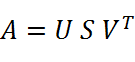

где матрицы U и V – ортогональные, а S – диагональная матрица, значения на диагонали которой называются сингулярными значениями матрицы A.

Особенность такого разложения в том, что если в матрице S оставить только k наибольших сингулярных значений, то линейная комбинация получившихся матриц будет наилучшим приближением исходной матрицы A к матрице Ă ранга k:

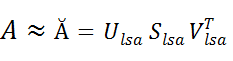

<b>Основная идея латентно-семантического анализа состоит в следующем:
после перемножения матриц полученная матрица Ă, содержащая только k первых линейно независимых компонент исходной матрицы A, отражает структуру зависимостей (в данном случае ассоциативных), латентно присутствующих в исходной матрице. Структура зависимостей определяется весовыми функциями термов для каждого документа.</b> 

<h3>Реализация LSA на Python с использованием <b>Gensim</b></h3><br>
<b>Gensim</b> – это библиотека с открытым исходным кодом на Python, написанная Радимом Рехуреком, которая используется для тематического моделирования без учителя и обработки естественного языка (NLP). Она предназначена для извлечения семантических тем из документов.

In [67]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [68]:
#загрузка модулей
#здесь используется дополнительный модуль NTLK с собственным интерфейсом для загрузки стоп-слов (в качестве примера)
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [69]:
#загрузка данных
def load_data(path,file_name):
    """
    Входные данные  : путь и имя_файла
    Выходные данные : список статей/документов и заголовков (заголовком считаются первые 100 слов документа)
    
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [70]:
#предобработка данных
def preprocess_data(doc_set):
    """
    Входные данные: список документов
    Задача: создание токенов, уборка лишних слов
    Выходные данные: обработанный текст
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

In [71]:
#подготовка корпуса (список документов) и матрицы термов
def prepare_corpus(doc_clean):
    """
    Входные данные: чистый документ
    Задача: создание словаря термов и конвертация списка документов в матрицу термов
    Выходные данные: словарь термов и матрица термов
    """
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary,doc_term_matrix

In [72]:
#создание модели LSA
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Входные данные: чистый документ, количество тем и слова, ассоциирующиеся с каждой темой
    Выходные данные: модель LSA
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

Проверим работу программы

In [81]:
number_of_topics=7
words=10
document_list,titles=load_data("",r'C:\articles.txt') #здесь требуется указать свой путь
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 7516
[(0, '0.574*"text" + 0.418*"imag" + 0.334*"use" + 0.319*"one" + 0.244*"electron" + 0.119*"librari" + 0.094*"materi" + 0.085*"network" + 0.083*"digit" + 0.078*"project"'), (1, '-0.733*"text" + 0.377*"one" + 0.320*"use" + 0.231*"librari" + 0.170*"imag" + 0.137*"network" + -0.089*"electron" + 0.082*"inform" + 0.081*"materi" + 0.073*"digit"'), (2, '0.760*"imag" + -0.568*"one" + -0.151*"text" + -0.126*"use" + 0.094*"digit" + 0.059*"scan" + -0.058*"electron" + 0.058*"qualiti" + 0.057*"captur" + 0.041*"manag"'), (3, '0.695*"use" + -0.571*"one" + -0.291*"imag" + 0.219*"electron" + 0.081*"materi" + 0.075*"librari" + 0.052*"technolog" + 0.045*"research" + 0.042*"resourc" + 0.041*"inform"'), (4, '-0.764*"librari" + 0.398*"use" + -0.207*"electron" + -0.177*"project" + 0.172*"imag" + 0.165*"one" + -0.115*"network" + -0.110*"public" + -0.107*"congress" + -0.088*"access"'), (5, '-0.837*"electron" + 0.328*"librari" + 0.238*"text" + 0.219*"use" + -0.104*"publish" + -0.08

Таким образом, мы получаем список тем, представленных в текстах, и самые популярные термы, использующиеся в них. Некоторые темы могут накладываться друг на друга.

<h3>Пример работы программы на моих данных (использовался  Workshop on Electronic Texts: Proceedings из Project Gutenberg)</h3>

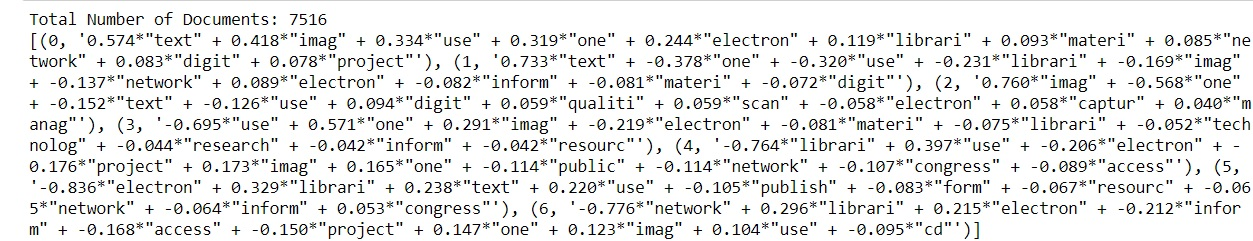

<hr>
Действия, представленные ниже, не обязательны. Они нужны для оптимизации и представления статистического графика согласованности тем (работает очень долго)

In [82]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [83]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Количество топиков")
    plt.ylabel("Оценка согласованности")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

<h3>Пример получившегося графика</h3>

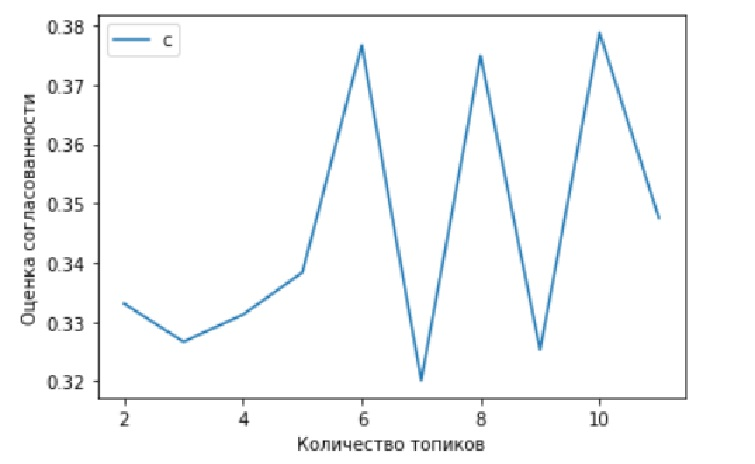